In [1]:
!mkdir -p coco/images

!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip -d coco/images
!rm train2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: coco/images/train2017/000000259556.jpg  
 extracting: coco/images/train2017/000000381931.jpg  
 extracting: coco/images/train2017/000000569592.jpg  
 extracting: coco/images/train2017/000000229396.jpg  
 extracting: coco/images/train2017/000000488990.jpg  
 extracting: coco/images/train2017/000000348684.jpg  
 extracting: coco/images/train2017/000000234031.jpg  
 extracting: coco/images/train2017/000000563584.jpg  
 extracting: coco/images/train2017/000000276069.jpg  
 extracting: coco/images/train2017/000000401194.jpg  
 extracting: coco/images/train2017/000000502089.jpg  
 extracting: coco/images/train2017/000000192183.jpg  
 extracting: coco/images/train2017/000000425127.jpg  
 extracting: coco/images/train2017/000000126766.jpg  
 extracting: coco/images/train2017/000000324161.jpg  
 extracting: coco/images/train2017/000000452746.jpg  
 extracting: coco/images/train2017/000000423782.jpg  
 extracting: coco/images/train2

In [2]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from fastai.vision.all import *
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet34
from fastai.vision.models.unet import DynamicUnet
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(123)

In [4]:
class ColorizationDataset(Dataset):
    def __init__(self, image_paths, split, img_size=256):
        self.transforms = transforms.Compose([
            transforms.Resize((img_size, img_size), Image.BICUBIC),
            transforms.RandomHorizontalFlip() if split == "train" else transforms.Resize((img_size, img_size), Image.BICUBIC)
        ])
        self.image_paths = image_paths
        self.split = split

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50.0 - 1.0
        ab = img_lab[[1, 2], ...] / 110.0
        return {"L": L, "ab": ab}

    def __len__(self):
        return len(self.image_paths)

In [5]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count = 0
        self.avg = 0.0
        self.sum = 0.0

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

In [6]:
def create_loss_meters():
    return {
        "loss_D_fake": AverageMeter(),
        "loss_D_real": AverageMeter(),
        "loss_D": AverageMeter(),
        "loss_G_GAN": AverageMeter(),
        "loss_G_L1": AverageMeter(),
        "loss_G": AverageMeter()
    }

In [7]:
def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

In [8]:
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [9]:
class ColorizationDiscriminator(nn.Module):
    def __init__(self, input_channels=3, base_filters=64, num_layers=3):
        super(ColorizationDiscriminator, self).__init__()
        layers = [nn.Conv2d(input_channels, base_filters, kernel_size=4, stride=2, padding=1)]
        filters = base_filters

        for _ in range(num_layers):
            layers.append(nn.Conv2d(filters, filters * 2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(filters * 2))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            filters *= 2

        layers.append(nn.Conv2d(filters, 1, kernel_size=4, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [10]:
class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, prediction, target_is_real):
        target_tensor = torch.full_like(prediction, 1.0 if target_is_real else 0.0)
        return self.loss(prediction, target_tensor)

In [11]:
class ColorizationModel:
    def __init__(self, generator, discriminator, device, lambda_l1=100.0, lr_G=0.0002, lr_D=0.0002, beta1=0.5, beta2=0.999):
        self.device = device
        self.lambda_l1 = lambda_l1

        self.G_net = generator.to(device)
        self.D_net = discriminator.to(device)

        self.GAN_loss = GANLoss().to(device)
        self.L1_loss = nn.L1Loss()

        self.opt_G = optim.Adam(self.G_net.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.D_net.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for param in model.parameters():
            param.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data["L"].to(self.device)
        self.ab = data["ab"].to(self.device)

    def forward(self):
        self.fake_color = self.G_net(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.D_net(fake_image.detach())
        self.loss_D_fake = self.GAN_loss(fake_preds, False)

        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.D_net(real_image)
        self.loss_D_real = self.GAN_loss(real_preds, True)

        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.D_net(fake_image)
        self.loss_G_GAN = self.GAN_loss(fake_preds, True)
        self.loss_G_L1 = self.L1_loss(self.fake_color, self.ab) * self.lambda_l1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()

        self.set_requires_grad(self.D_net, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.set_requires_grad(self.D_net, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [12]:
def save_checkpoint(model, epoch, path='checkpoint.pth'):
    checkpoint = {
        'G_net_state_dict': model.G_net.state_dict(),
    }
    torch.save(checkpoint, path)

In [13]:
def visualize_results(model, val_loader, num_images=2):
    model.G_net.eval()
    data = next(iter(val_loader))
    model.setup_input(data)
    with torch.no_grad():
        model.forward()

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    for i in range(num_images):
        L = model.L[i].cpu().numpy().transpose(1, 2, 0) * 50.0 + 50.0
        ab = model.ab[i].cpu().numpy().transpose(1, 2, 0) * 110.0
        fake_ab = model.fake_color[i].cpu().numpy().transpose(1, 2, 0) * 110.0

        real_image = np.concatenate((L, ab), axis=2)
        fake_image = np.concatenate((L, fake_ab), axis=2)

        axes[i, 0].imshow(L[:, :, 0], cmap='gray')
        axes[i, 0].set_title("Input (L channel)")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(lab2rgb(fake_image))
        axes[i, 1].set_title("Generated (Lab to RGB)")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(lab2rgb(real_image))
        axes[i, 2].set_title("Ground Truth (Lab to RGB)")
        axes[i, 2].axis('off')

    plt.show()

In [14]:
def build_generator(n_input=1, n_output=2, size=(256, 256)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = create_body(resnet34(), pretrained=True, n_in=n_input, cut=-2)
    generator = DynamicUnet(backbone, n_output, size).to(device)
    return generator

In [15]:
def pretrain_generator(generator, train_loader, num_epochs=10, lr=0.0002):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        epoch_loss = AverageMeter()
        for data in tqdm(train_loader):
            L = data["L"].to(device)
            ab = data["ab"].to(device)

            optimizer.zero_grad()
            fake_ab = generator(L)
            loss = criterion(fake_ab, ab)
            loss.backward()
            optimizer.step()

            epoch_loss.update(loss.item(), L.size(0))

        print(f"Pretrain Epoch {epoch+1}/{num_epochs} completed. Loss: {epoch_loss.avg:.4f}")

In [16]:
def train_colorization_model(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.G_net.train()
        model.D_net.train()

        loss_meter_dict = create_loss_meters()
        i = 0

        for data in tqdm(train_loader):
            i += 1
            model.setup_input(data)
            model.optimize()

            update_losses(model, loss_meter_dict, count=data['L'].size(0))

            if (i + 1) % 100 == 0:
                print(f"Batch {i+1}/{len(train_loader)}")
                log_results(loss_meter_dict)

        print(f"Epoch {epoch+1}/{num_epochs} completed.")
        save_checkpoint(model, epoch + 1)
        visualize_results(model, val_loader)
        log_results(loss_meter_dict)

In [20]:
data_path = 'coco/images/train2017'

# randomly selecting 20k images (16k training and 4k validation)
img_paths = glob.glob(data_path + "/*.jpg")
img_paths_sub = np.random.choice(img_paths, 20000, replace=False)
rand_ids = np.random.permutation(20000)
train_ids = rand_ids[:16000]
train_paths = img_paths_sub[train_ids]
val_ids = rand_ids[16000:]
val_paths = img_paths_sub[val_ids]
print("Train size: ", len(train_paths))
print("Val size: ", len(val_paths))

Train size:  16000
Val size:  4000


In [21]:
batch_size = 32
train_dataset = ColorizationDataset(image_paths=train_paths, split='train')
val_dataset = ColorizationDataset(image_paths=val_paths, split='val')

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

print(f"Number of training batches: {len(train_loader)}, Number of validation batches: {len(val_loader)}")

Number of training batches: 500, Number of validation batches: 125


In [19]:
discriminator = ColorizationDiscriminator()

generator = build_generator()
if os.path.exists('generator.pt'):
  generator.load_state_dict(torch.load('generator.pt', map_location=device))
else:
  pretrain_generator(generator, train_loader)
  torch.save(generator.state_dict(), 'generator.pt')

100%|██████████| 563/563 [12:04<00:00,  1.29s/it]


Pretrain Epoch 1/10 completed. Loss: 0.0958


100%|██████████| 563/563 [12:08<00:00,  1.29s/it]


Pretrain Epoch 2/10 completed. Loss: 0.0832


100%|██████████| 563/563 [12:05<00:00,  1.29s/it]


Pretrain Epoch 3/10 completed. Loss: 0.0823


100%|██████████| 563/563 [12:03<00:00,  1.28s/it]


Pretrain Epoch 4/10 completed. Loss: 0.0815


100%|██████████| 563/563 [11:53<00:00,  1.27s/it]


Pretrain Epoch 5/10 completed. Loss: 0.0808


100%|██████████| 563/563 [11:46<00:00,  1.25s/it]


Pretrain Epoch 6/10 completed. Loss: 0.0804


100%|██████████| 563/563 [11:43<00:00,  1.25s/it]


Pretrain Epoch 7/10 completed. Loss: 0.0800


100%|██████████| 563/563 [11:43<00:00,  1.25s/it]


Pretrain Epoch 8/10 completed. Loss: 0.0798


100%|██████████| 563/563 [11:52<00:00,  1.27s/it]


Pretrain Epoch 9/10 completed. Loss: 0.0794


100%|██████████| 563/563 [11:58<00:00,  1.28s/it]


Pretrain Epoch 10/10 completed. Loss: 0.0792


 20%|█▉        | 99/500 [02:46<11:04,  1.66s/it]

Batch 100/500
loss_D_fake: 0.52022
loss_D_real: 0.52710
loss_D: 0.52366
loss_G_GAN: 1.26841
loss_G_L1: 8.97677
loss_G: 10.24517


 40%|███▉      | 199/500 [05:32<08:19,  1.66s/it]

Batch 200/500
loss_D_fake: 0.52378
loss_D_real: 0.53360
loss_D: 0.52869
loss_G_GAN: 1.26392
loss_G_L1: 9.25714
loss_G: 10.52106


 60%|█████▉    | 299/500 [08:19<05:33,  1.66s/it]

Batch 300/500
loss_D_fake: 0.52552
loss_D_real: 0.54322
loss_D: 0.53437
loss_G_GAN: 1.25406
loss_G_L1: 9.40201
loss_G: 10.65607


 80%|███████▉  | 399/500 [11:05<02:47,  1.66s/it]

Batch 400/500
loss_D_fake: 0.52782
loss_D_real: 0.55155
loss_D: 0.53969
loss_G_GAN: 1.25058
loss_G_L1: 9.48789
loss_G: 10.73847


100%|█████████▉| 499/500 [13:51<00:01,  1.66s/it]

Batch 500/500
loss_D_fake: 0.53506
loss_D_real: 0.55493
loss_D: 0.54499
loss_G_GAN: 1.23438
loss_G_L1: 9.51053
loss_G: 10.74491


100%|██████████| 500/500 [13:53<00:00,  1.67s/it]


Epoch 1/10 completed.


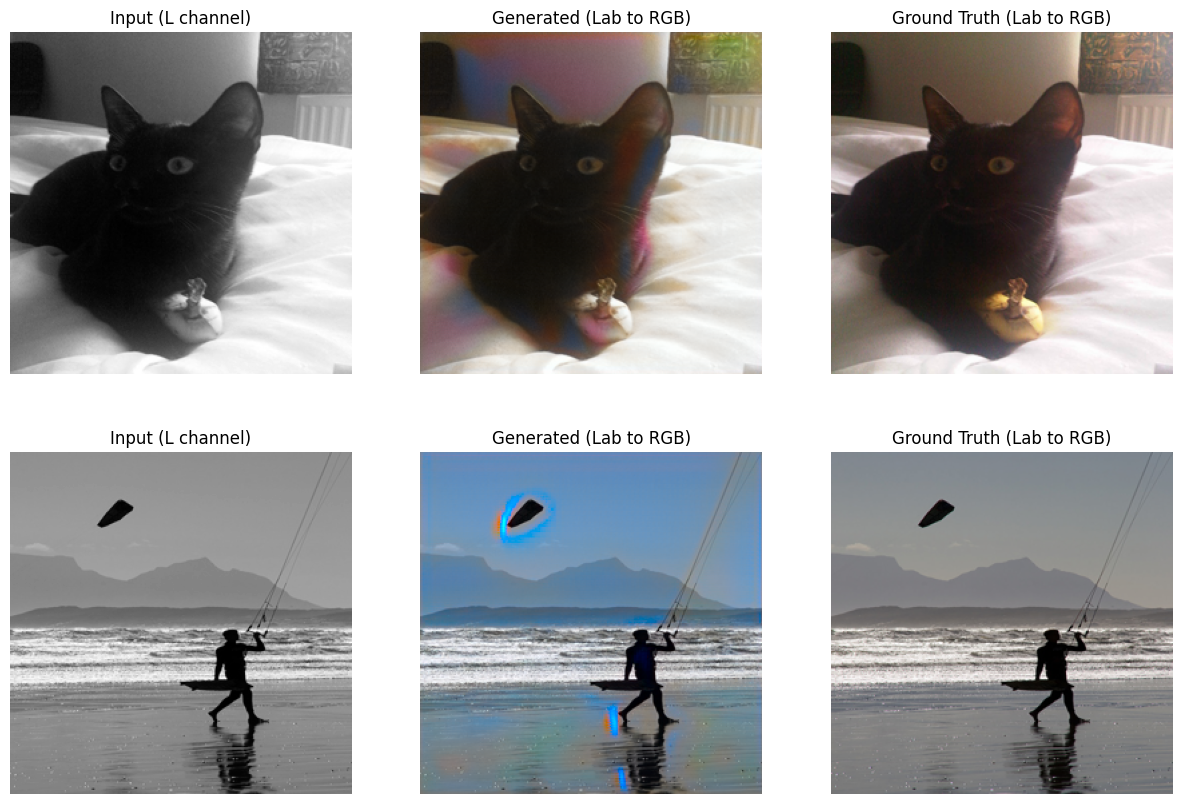

loss_D_fake: 0.53554
loss_D_real: 0.55498
loss_D: 0.54526
loss_G_GAN: 1.23377
loss_G_L1: 9.50996
loss_G: 10.74373


 20%|█▉        | 99/500 [02:45<11:06,  1.66s/it]

Batch 100/500
loss_D_fake: 0.54665
loss_D_real: 0.57250
loss_D: 0.55957
loss_G_GAN: 1.16638
loss_G_L1: 9.71027
loss_G: 10.87665


 40%|███▉      | 199/500 [05:32<08:20,  1.66s/it]

Batch 200/500
loss_D_fake: 0.55675
loss_D_real: 0.56860
loss_D: 0.56268
loss_G_GAN: 1.18111
loss_G_L1: 9.73495
loss_G: 10.91606


 60%|█████▉    | 299/500 [08:18<05:33,  1.66s/it]

Batch 300/500
loss_D_fake: 0.55454
loss_D_real: 0.57700
loss_D: 0.56577
loss_G_GAN: 1.17047
loss_G_L1: 9.76536
loss_G: 10.93583


 80%|███████▉  | 399/500 [11:04<02:47,  1.66s/it]

Batch 400/500
loss_D_fake: 0.55365
loss_D_real: 0.57956
loss_D: 0.56660
loss_G_GAN: 1.17506
loss_G_L1: 9.81538
loss_G: 10.99044


100%|█████████▉| 499/500 [13:50<00:01,  1.66s/it]

Batch 500/500
loss_D_fake: 0.55520
loss_D_real: 0.58006
loss_D: 0.56763
loss_G_GAN: 1.16710
loss_G_L1: 9.80774
loss_G: 10.97484


100%|██████████| 500/500 [13:51<00:00,  1.66s/it]


Epoch 2/10 completed.


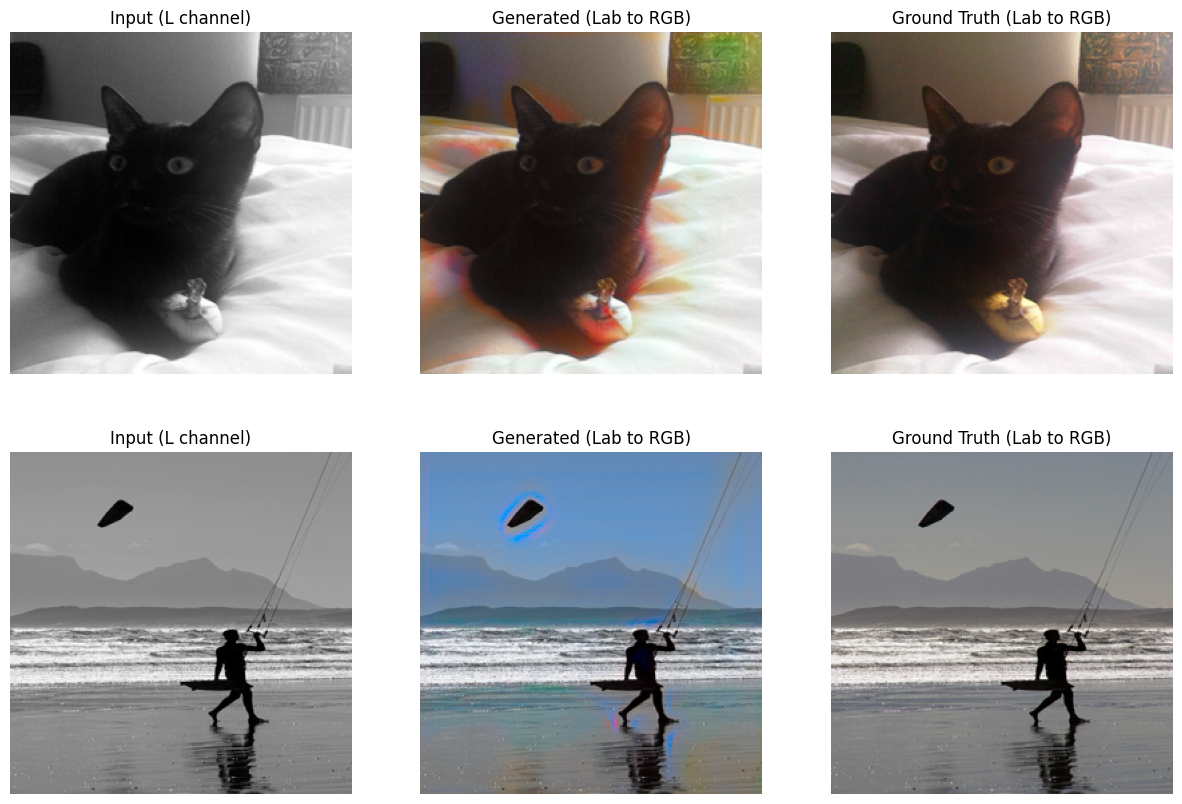

loss_D_fake: 0.55598
loss_D_real: 0.58011
loss_D: 0.56804
loss_G_GAN: 1.16709
loss_G_L1: 9.80654
loss_G: 10.97363


 20%|█▉        | 99/500 [02:45<11:07,  1.66s/it]

Batch 100/500
loss_D_fake: 0.54739
loss_D_real: 0.58360
loss_D: 0.56549
loss_G_GAN: 1.14932
loss_G_L1: 9.85079
loss_G: 11.00012


 40%|███▉      | 199/500 [05:31<08:17,  1.65s/it]

Batch 200/500
loss_D_fake: 0.55263
loss_D_real: 0.59693
loss_D: 0.57478
loss_G_GAN: 1.14755
loss_G_L1: 9.89281
loss_G: 11.04036


 60%|█████▉    | 299/500 [08:17<05:33,  1.66s/it]

Batch 300/500
loss_D_fake: 0.55074
loss_D_real: 0.59675
loss_D: 0.57375
loss_G_GAN: 1.14354
loss_G_L1: 9.90254
loss_G: 11.04609


 80%|███████▉  | 399/500 [11:02<02:48,  1.67s/it]

Batch 400/500
loss_D_fake: 0.55257
loss_D_real: 0.60102
loss_D: 0.57680
loss_G_GAN: 1.13772
loss_G_L1: 9.92229
loss_G: 11.06001


100%|█████████▉| 499/500 [13:48<00:01,  1.66s/it]

Batch 500/500
loss_D_fake: 0.55458
loss_D_real: 0.60170
loss_D: 0.57814
loss_G_GAN: 1.12812
loss_G_L1: 9.89041
loss_G: 11.01852


100%|██████████| 500/500 [13:50<00:00,  1.66s/it]


Epoch 3/10 completed.


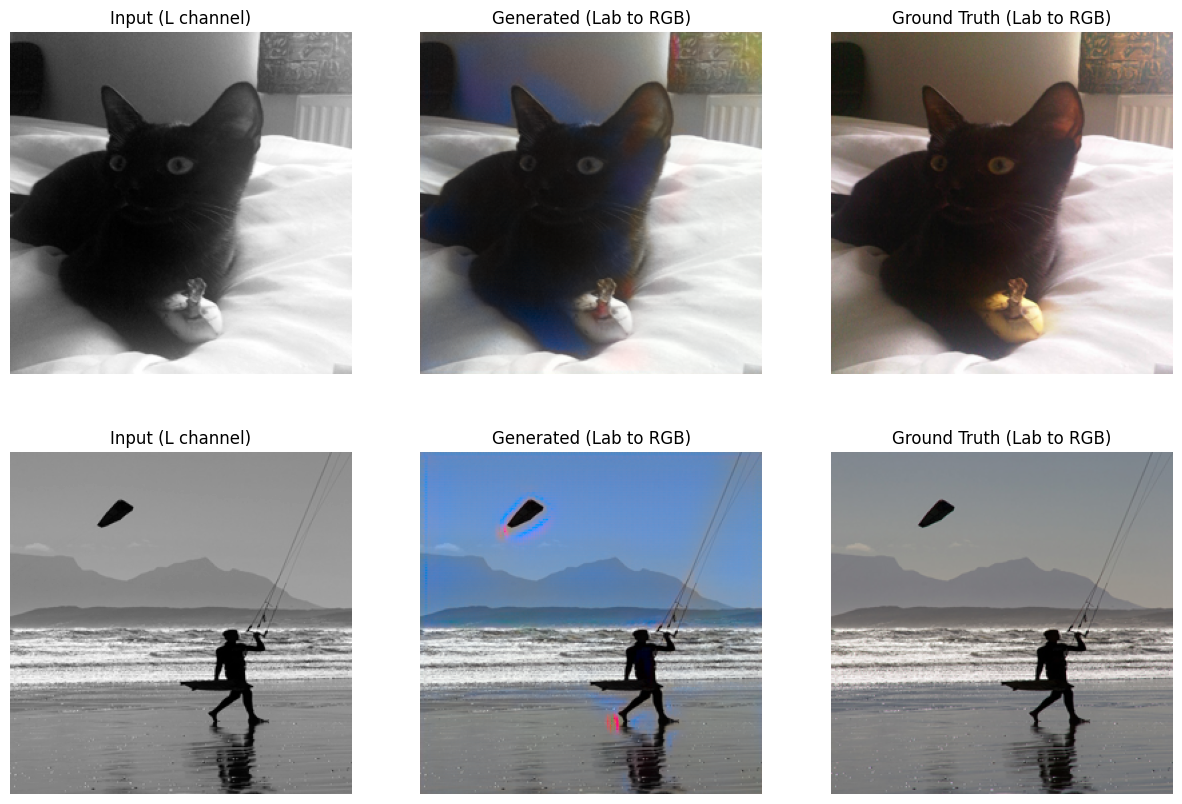

loss_D_fake: 0.55515
loss_D_real: 0.60147
loss_D: 0.57831
loss_G_GAN: 1.12780
loss_G_L1: 9.88929
loss_G: 11.01709


 20%|█▉        | 99/500 [02:45<11:04,  1.66s/it]

Batch 100/500
loss_D_fake: 0.55846
loss_D_real: 0.59102
loss_D: 0.57474
loss_G_GAN: 1.11445
loss_G_L1: 9.88983
loss_G: 11.00428


 40%|███▉      | 199/500 [05:30<08:18,  1.66s/it]

Batch 200/500
loss_D_fake: 0.56478
loss_D_real: 0.60547
loss_D: 0.58512
loss_G_GAN: 1.10403
loss_G_L1: 9.88619
loss_G: 10.99023


 60%|█████▉    | 299/500 [08:16<05:33,  1.66s/it]

Batch 300/500
loss_D_fake: 0.56066
loss_D_real: 0.60278
loss_D: 0.58172
loss_G_GAN: 1.10509
loss_G_L1: 9.87905
loss_G: 10.98414


 80%|███████▉  | 399/500 [11:02<02:47,  1.66s/it]

Batch 400/500
loss_D_fake: 0.56248
loss_D_real: 0.60798
loss_D: 0.58523
loss_G_GAN: 1.10859
loss_G_L1: 9.89357
loss_G: 11.00217


100%|█████████▉| 499/500 [13:47<00:01,  1.65s/it]

Batch 500/500
loss_D_fake: 0.56182
loss_D_real: 0.60583
loss_D: 0.58383
loss_G_GAN: 1.10025
loss_G_L1: 9.86285
loss_G: 10.96310


100%|██████████| 500/500 [13:49<00:00,  1.66s/it]


Epoch 4/10 completed.


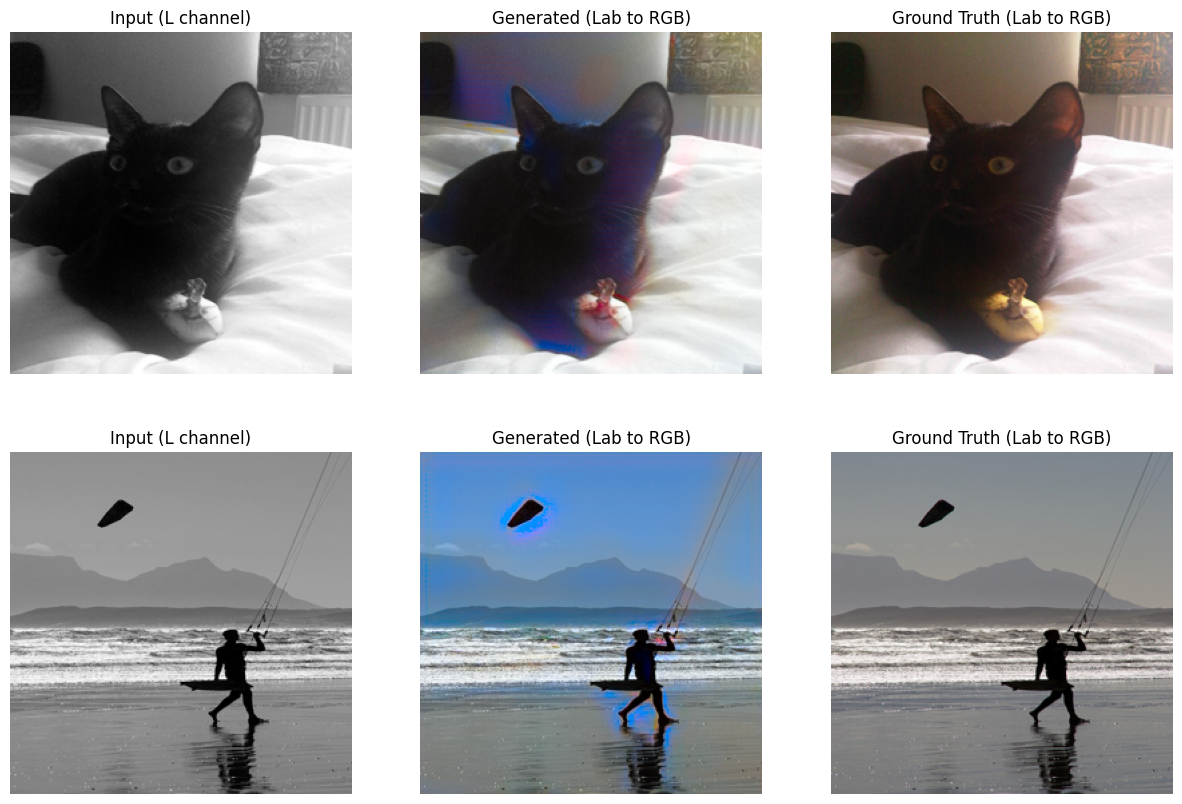

loss_D_fake: 0.56279
loss_D_real: 0.60537
loss_D: 0.58408
loss_G_GAN: 1.10016
loss_G_L1: 9.86137
loss_G: 10.96153


 20%|█▉        | 99/500 [02:45<11:07,  1.66s/it]

Batch 100/500
loss_D_fake: 0.57747
loss_D_real: 0.58997
loss_D: 0.58372
loss_G_GAN: 1.11922
loss_G_L1: 9.90436
loss_G: 11.02358


 40%|███▉      | 199/500 [05:30<08:19,  1.66s/it]

Batch 200/500
loss_D_fake: 0.57175
loss_D_real: 0.60345
loss_D: 0.58760
loss_G_GAN: 1.10125
loss_G_L1: 9.86375
loss_G: 10.96500


 60%|█████▉    | 299/500 [08:16<05:32,  1.65s/it]

Batch 300/500
loss_D_fake: 0.56599
loss_D_real: 0.60445
loss_D: 0.58522
loss_G_GAN: 1.09517
loss_G_L1: 9.86430
loss_G: 10.95947


 80%|███████▉  | 399/500 [11:01<02:46,  1.65s/it]

Batch 400/500
loss_D_fake: 0.56458
loss_D_real: 0.60778
loss_D: 0.58618
loss_G_GAN: 1.10744
loss_G_L1: 9.86902
loss_G: 10.97647


100%|█████████▉| 499/500 [13:46<00:01,  1.65s/it]

Batch 500/500
loss_D_fake: 0.56429
loss_D_real: 0.60139
loss_D: 0.58284
loss_G_GAN: 1.10405
loss_G_L1: 9.83357
loss_G: 10.93762


100%|██████████| 500/500 [13:48<00:00,  1.66s/it]


Epoch 5/10 completed.


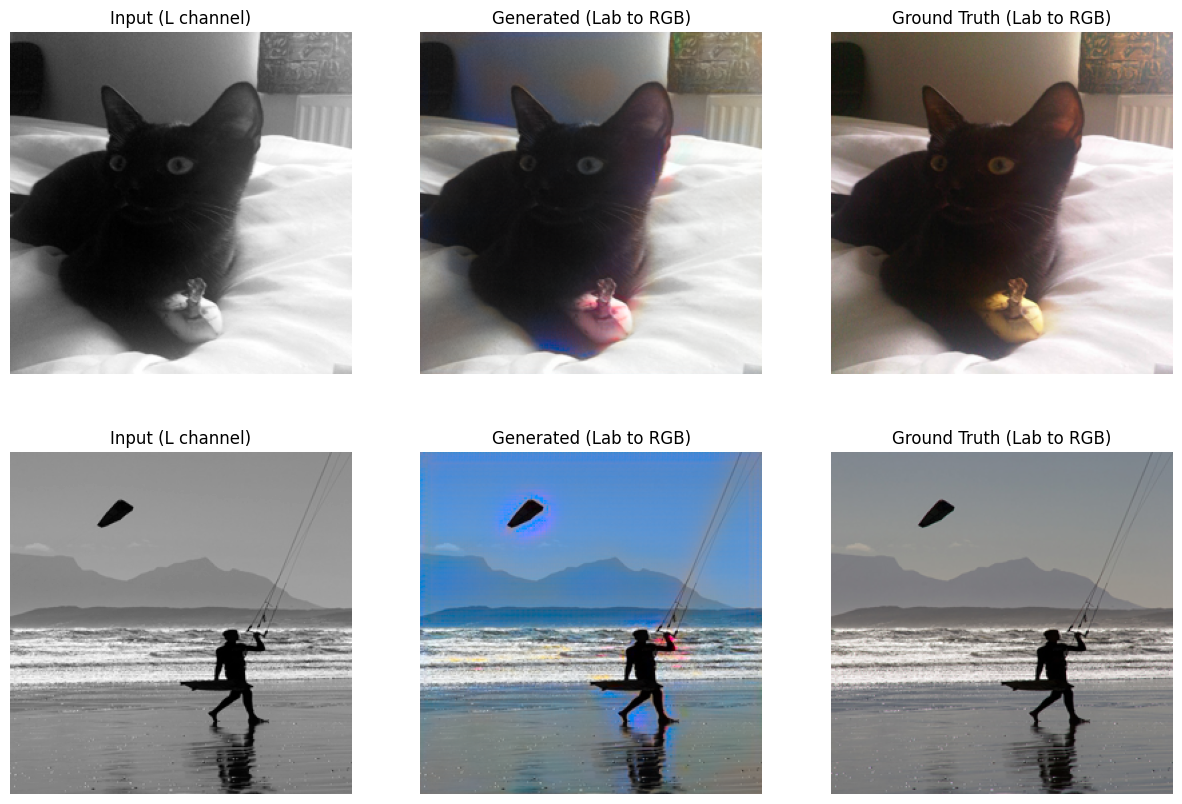

loss_D_fake: 0.56453
loss_D_real: 0.60156
loss_D: 0.58305
loss_G_GAN: 1.10349
loss_G_L1: 9.83242
loss_G: 10.93591


 20%|█▉        | 99/500 [02:44<11:05,  1.66s/it]

Batch 100/500
loss_D_fake: 0.55922
loss_D_real: 0.60020
loss_D: 0.57971
loss_G_GAN: 1.11882
loss_G_L1: 9.83900
loss_G: 10.95783


 30%|██▉       | 149/500 [04:09<09:47,  1.67s/it]


KeyboardInterrupt: 

In [22]:
colorization_model = ColorizationModel(generator, discriminator, device)
train_colorization_model(colorization_model, train_loader, val_loader)